In [1]:
import torch, torchvision
import albumentations as A
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

In [2]:
plt.rcParams['figure.figsize'] = (15,15)

# Load dataset

In [3]:
from sklearn.model_selection import train_test_split

image_dir, point_dir = 'images', 'points'
names = [f[:-4] for f in os.listdir(image_dir)]

train_set, test_set = train_test_split(names, test_size=0.2)

print(len(train_set))
print(len(test_set))

3253
814


In [4]:
from utils import add_points

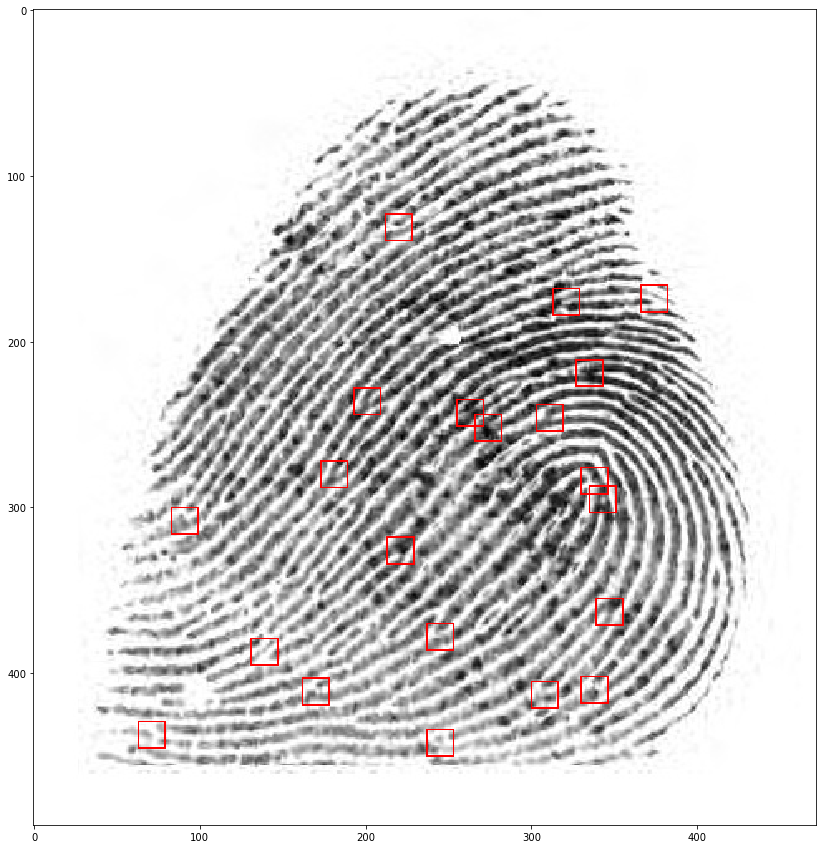

In [5]:
i = 123
image = cv2.imread(os.path.join(image_dir,train_set[i]+'.jpg'))/255.
points =  pd.read_csv(os.path.join(point_dir,train_set[i]+'.txt'), delimiter="\t").values
image = add_points(image,points)
plt.imshow(image)
plt.show()

In [6]:
SIZE = (53,53)
INTER_DIST = 21

## Define transformations

In [7]:
transform = A.Compose([
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5)], 
        keypoint_params = A.KeypointParams(format='xy'))

In [8]:
def apply_to_keypoint(self, keypoint,  **params):
    crop_coords = self.x_min, self.y_min, self.x_max, self.y_max
    return A.augmentations.functional.crop_keypoint_by_coords(keypoint, crop_coords, None,None,None,None)


A.Crop.apply_to_keypoint = apply_to_keypoint

## Create dataloaders

In [9]:
from finger_dataset import FingerDataset

In [10]:
cache_size = 5000
finger_ds = FingerDataset(train_set, image_dir, point_dir, transform, cache_size, SIZE, INTER_DIST)
train_loader = DataLoader(finger_ds, batch_size=256, shuffle=True, num_workers=4)
train_iter = iter(train_loader)

test_ds = FingerDataset(test_set, image_dir, point_dir, transform, 10000, SIZE, INTER_DIST)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True, num_workers=4)
test_iter = iter(test_loader)

## Look at the training data

In [11]:
from utils import grid, get_coord, compute_image_relative_coord

(32, 55, 55, 3)


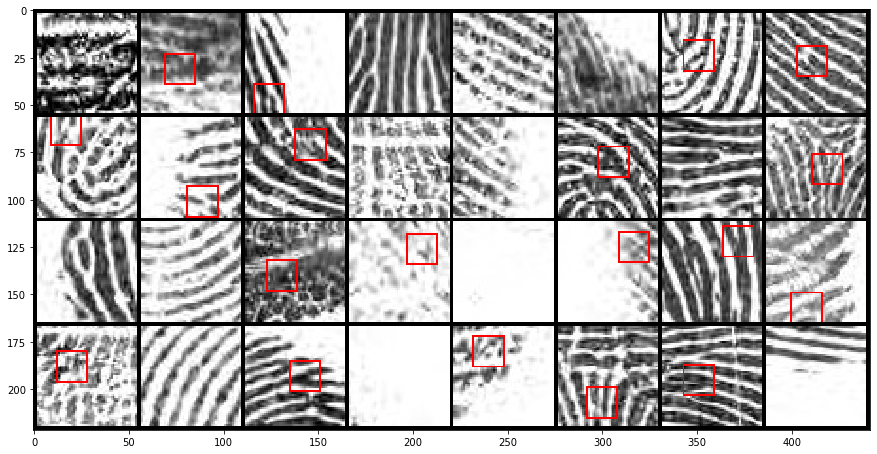

In [12]:
batch_x, batch_y  = train_iter.next()
points = get_coord(batch_y[:32,1:].numpy(), SIZE, INTER_DIST)
patches = batch_x[:32].permute(0,2,3,1)
sh = patches.shape
patches = patches.expand(sh[0],sh[1],sh[2],3).clone().cpu().numpy()
for i in range(patches.shape[0]):
    if batch_y[i,0] == 1:
        patches[i] = add_points(patches[i],[points[i]])

plt.imshow(grid(patches))
plt.show()

In [13]:
from yolo_like import YOLO

Model = YOLO(size=SIZE, inter_dist=INTER_DIST)

In [14]:
device = torch.device('cuda')
model = Model.to(device=device)
opt = torch.optim.Adam(params=model.parameters(), lr = 0.0008)
writer = SummaryWriter("logs")

In [15]:
def measure(logits, y_target, tol=0.0015):
    logits = logits.squeeze()
    pred = (logits[:,0] > 0) == y_target[:,0].to(torch.uint8)
    err = ((logits[:,1:]-y_target[:,1:])**2).sum(1) < tol
    return (pred*err).to(torch.float).mean()

In [16]:
# def train(model, num_iter, train_loader, train_ds, val_loader, val_ds, opt, loss_func, measure, device, writer):
#     model.train()
#     train_iterator = iter(train_loader)
#     print(len(train_iterator))
#     for i in range(num_iter):
#         try:
#             batch_x, batch_y = train_iterator.next()
#         except StopIteration:
#             train_iterator = iter(train_loader)
#             batch_x, batch_y = train_iterator.next()
#         train_ds.update_cache()
#         out = model(batch_x.to(device)) 
#         loss = loss_func(out, batch_y.to(device))
#         loss.backward()
#         opt.step()
#         opt.zero_grad()
#         if i%10 == 0:
#             writer.add_scalar('data/loss', loss, i)
#         if i%100 == 0:
#             model.eval()
#             try:
#                 batch_x, batch_y = val_iterator.next()
#             except StopIteration:
#                 val_iterator = iter(val_loader)
#                 batch_x, batch_y = val_iterator.next()
#             with torch.no_grad():
#                 acc = measure(model(batch_x.to(device)), batch_y.to(device))
#             writer.add_scalar('data/val_accuracy', acc, i)
#             val_ds.update_cache()
#             model.train()
#         if i%100 == 0:
#             print('iteration ' + str(i))

In [17]:
# train(model, 80000, train_loader, finger_ds, opt, loss, None, device, writer)

In [18]:
# torch.save(model.state_dict, '80000.state_dict')

In [19]:
model.net.load_state_dict(torch.load('150000.state_dict')())
model.eval()

YOLO(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (16): 

In [20]:
batch_x, batch_y  = test_iter.next()
out = model(batch_x.cuda()).detach().squeeze()

(32, 55, 55, 3)


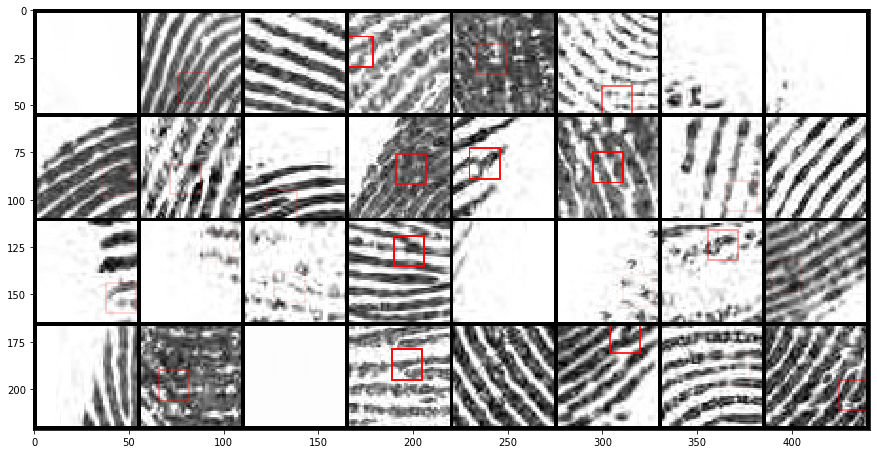

In [21]:
prob = torch.sigmoid(out[:,0])
points = get_coord(out[:32,1:].cpu().numpy(), SIZE, INTER_DIST).round().astype('int')
patches = batch_x[:32].permute(0,2,3,1)
sh = patches.shape
patches = patches.expand(sh[0],sh[1],sh[2],3).clone().cpu().numpy()
for i in range(patches.shape[0]):
    patches[i] = add_points(patches[i],[points[i]], p=float(prob[i]))

plt.imshow(grid(patches))
plt.show()

(32, 55, 55, 3)


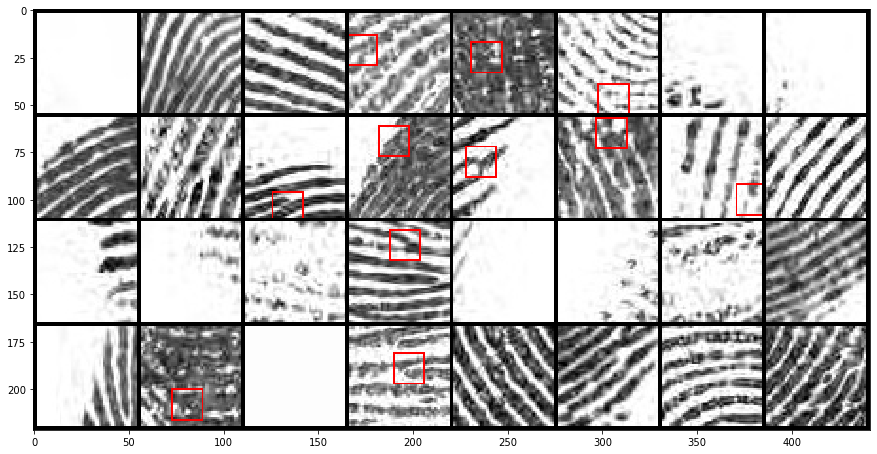

In [22]:
points = get_coord(batch_y[:32,1:].cpu().numpy(), SIZE, INTER_DIST).round().astype('int')
patches = batch_x[:32].permute(0,2,3,1)
sh = patches.shape
patches = patches.expand(sh[0],sh[1],sh[2],3).clone().cpu().numpy()
for i in range(patches.shape[0]):
    if batch_y[i,0] == 1:
        patches[i] = add_points(patches[i],[points[i]])

plt.imshow(grid(patches))
plt.show()

In [23]:
threshold = 0.7
i = 13
image = cv2.imread(os.path.join(image_dir,train_set[i]+'.jpg'), 2)/255.
points =  pd.read_csv(os.path.join(point_dir,train_set[i]+'.txt'), delimiter="\t").values
coord, prob = model.predict(image,threshold=0.5)

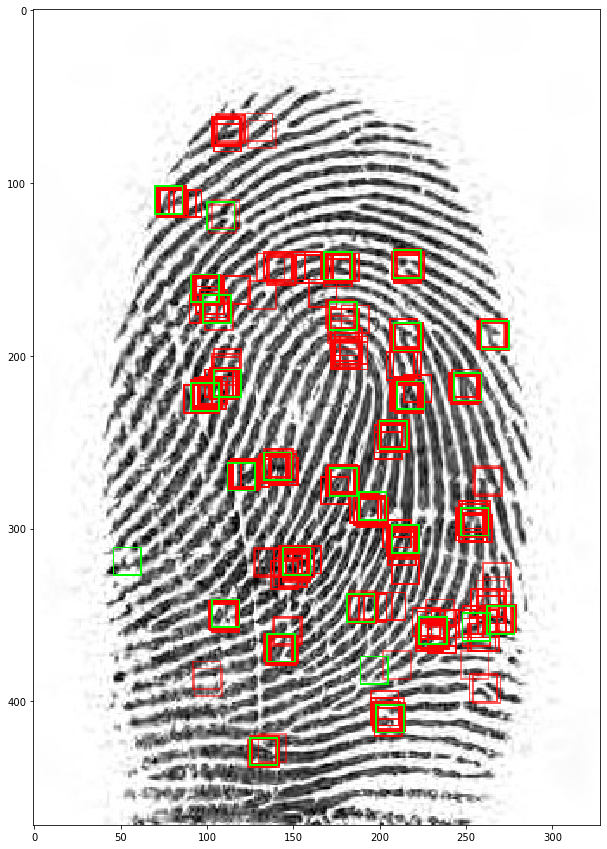

In [24]:
image = cv2.imread(os.path.join(image_dir,train_set[i]+'.jpg'))/255.
image = add_points(image,coord, p=prob)
image = add_points(image,points, p=1, rgb_color=(0,1,0))
plt.imshow(image)
plt.show()